### Gibbs Sampling Demo for Multivariate Normal Distribution

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy.linalg import det, inv

In [2]:
def rearrange_cov_mat(Sigma, idx):
    """
    Rearrange the covariance matrix 
    
    @param Sigma
        covariance matrix
    @param idx
        integer index (index of dimension for full conditional distribution derivation)
    """
    new_cov = np.zeros(Sigma.shape)
    
    # four sub blocks
    cov_ul = Sigma[:idx, :idx]
    cov_ur = Sigma[:idx, (idx + 1):]
    cov_ll = Sigma[(idx + 1):, :idx]
    cov_lr = Sigma[(idx + 1):, (idx + 1):]
    
    # four slices
    cov_upper = Sigma[:idx, idx]
    cov_lower = Sigma[(idx + 1):, idx]
    cov_left  = Sigma[idx, :idx]
    cov_right = Sigma[idx, (idx + 1):]
    
    new_cov[0, 0]   = Sigma[idx, idx]
    new_cov[1:, 0]  = np.concatenate((cov_upper, cov_lower))
    new_cov[0, 1:]  = np.concatenate((cov_left, cov_right))
    new_cov[1:, 1:] = np.concatenate((np.concatenate((cov_ul, cov_ur), axis = 1),
                                      np.concatenate((cov_ll, cov_lr), axis = 1)), axis = 0)
    
    return new_cov


def full_conditional(x, idx, mu, Sigma):
    """
    Calculate the full conditional distribution mean and variance of multivariate normal
    
    @param x
        random vector to be conditioning on (whole dimension)
    @param idx
        integer index
    @param mu
        mean vector 
    @param Sigma
        covariance matrix
    """
    if idx < 0 or idx > len(x) - 1:
        return "Variable index out of bound"
    
    cond_x  = np.append(x[:idx], x[(idx + 1):])
    cond_mu = np.append(mu[:idx], mu[(idx + 1):])
    new_cov = rearrange_cov_mat(Sigma, idx)
    
    # covariances
    Sigma_11, Sigma_12, Sigma_22 = new_cov[0, 0], new_cov[0, 1:], new_cov[1:, 1:]
    
    # conditional mean and covariance
    b = mu[idx] + (1. / Sigma_11) * Sigma_12.T.dot((cond_x - cond_mu))
    A = Sigma_22 - (1. / Sigma_11) * Sigma_12.T.dot(Sigma_12)
    
    return b, A[0]

In [3]:
def gibbs_sampler(init, mu, Sigma, S = 10000):
    """
    Gibbs sampler for multivariate normal
    
    @param init
        initial random vector
    @param mu
        mean vector
    @param Sigma
        covariance matrix
    @param S
        sample size
    """
    D = len(init)
    sample = np.zeros((S, D))
    sample[0, :] = init
    
    for s in range(1, S):
        for d in range(D):
            if d == 0:
                cond = sample[s - 1, :]
            elif d == D:
                cond = sample[s, :]
            else:
                cond = np.append(sample[s, :(d + 1)], sample[s - 1, (d + 1):])
            
            mean, var = full_conditional(cond, d, mu, Sigma)
            sample[s, d] = np.random.normal(loc = mean, scale = np.sqrt(var))
    
    return sample

### Two Dimension Data Demo

Sample mean:
[-0.01047527  0.99476823]

Theoretical mean:
[0 1]

Sample covariance:
[[ 1.22299719 -0.72874056]
 [-0.72874056  1.24174053]]

Theoretical covariance:
[[ 1.25 -0.75]
 [-0.75  1.25]]



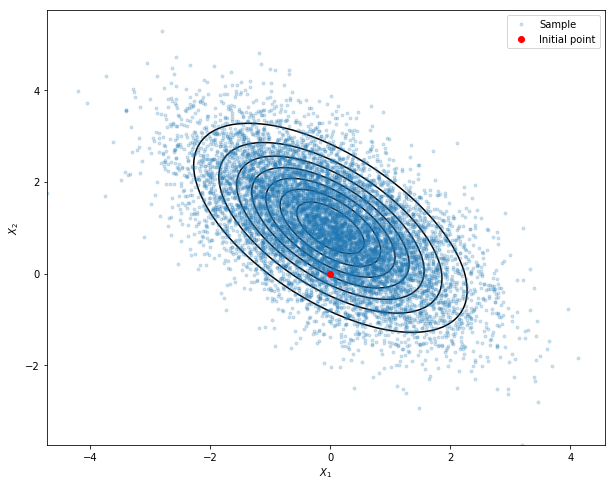

In [4]:
mu = np.array([0, 1])
Sigma = np.array([[1.25, -.75],
                  [-.75, 1.25]])
init = np.array([0, 0])

sample = gibbs_sampler(init, mu, Sigma)

print("Sample mean:\n{}\n".format(np.mean(sample, axis = 0)))
print("Theoretical mean:\n{}\n".format(mu))
print("Sample covariance:\n{}\n".format(np.cov(sample.T)))
print("Theoretical covariance:\n{}\n".format(Sigma))

# Theoretical density
def bivariate_normal(x1, x2, mu, Sigma):
    """
    Calculate the density of bivariate normal distribution
    """
    x = np.array([x1, x2])
    const = (2 * np.pi) ** (-len(x)/2) * det(Sigma) ** (-.5)
    return const * np.exp(-.5 * ((x - mu).dot(inv(Sigma))).dot(x - mu))

# Generate grids
sample_x = np.arange(np.min(sample[:, 0]), np.max(sample[:, 0]), .1)
sample_y = np.arange(np.min(sample[:, 1]), np.max(sample[:, 1]), .1)
sample_X, sample_Y = np.meshgrid(sample_x, sample_y)

sample_Z = np.zeros_like(sample_X)
for i in range(sample_Z.shape[0]):
    for j in range(sample_Z.shape[1]):
        sample_Z[i, j] = bivariate_normal(sample_X[i, j], sample_Y[i, j], mu, Sigma)

# Visualization
mpl.rcParams["figure.figsize"] = 10, 8
plt.contour(sample_X, sample_Y, sample_Z, colors = "black")
plt.plot(sample[:, 0], sample[:, 1], '.', alpha = 0.2)
plt.plot(sample[0, 0], sample[0, 1], 'ro')
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.legend(["Sample", "Initial point"])
plt.show()